In [18]:
!pip install -r requirements_pip.txt

In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import matplotlib.pyplot as plt
import itertools
import plotly.express as px
import numpy as np
from sklearn.metrics import confusion_matrix

2026-02-26 15:05:12.079000: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#reproducibility
SEED = 42
tf.keras.utils.set_random_seed(SEED)

print("TensorFlow version:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices("GPU")) > 0)

TensorFlow version: 2.20.0
GPU available: True


In [3]:

DATA_DIR = "ConvNet_dataset"  #expects: ConvNet_dataset/training_set and ConvNet_dataset/test_set

train_dir = os.path.join(DATA_DIR, "training_set")
test_dir  = os.path.join(DATA_DIR, "test_set")

print("train_dir:", train_dir)
print("test_dir :", test_dir)

#quick folder check
for p in [train_dir, test_dir]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing folder: {p}")

print("train classes:", os.listdir(train_dir))
print("test classes :", os.listdir(test_dir))

train_dir: ConvNet_dataset/training_set
test_dir : ConvNet_dataset/test_set
train classes: ['.DS_Store', 'cats', 'dogs']
test classes : ['.DS_Store', 'cats', 'dogs']


In [4]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

#load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Class names:", class_names)  

Found 8000 files belonging to 2 classes.


I0000 00:00:1772139915.082091   55442 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9556 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 2000 files belonging to 2 classes.
Class names: ['cats', 'dogs']


In [5]:
#understanding how many parallel calls to make when loading data
AUTOTUNE = tf.data.AUTOTUNE

#cache datasets for performance and prefetch to overlap data loading and model execution
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
#data augmentation (train only), this will randomly flip, rotate, and zoom images during training to help the model generalize better.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
])

#normalization of pixel values to [0,1] range, this helps the model train faster and can improve performance.
normalizer = layers.Rescaling(1./255)

In [7]:
#model
model = models.Sequential([
    # three color channels (RGB)
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    data_augmentation,
    normalizer,
    #convolutional layers with increasing filter sizes to learn hierarchical features, max pooling to reduce spatial dimensions and control overfitting, dropout for regularization, and dense layers for classification.
    layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(),
    #more filters in deeper layers to capture more complex features
    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(),
    #even deeper layer with more filters to capture high-level features
    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(),
    #forces the model to learn more robust features by randomly dropping out neurons during training, which helps prevent overfitting.
    layers.Dropout(0.25),

    layers.Flatten(),
    #fully connected layer to learn non-linear combinations of the features extracted by the convolutional layers, with dropout for regularization.
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.30),

    layers.Dense(1, activation="sigmoid")  #binary output
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
#7 trainable layers (3 conv + 2 dense + 2 dropout)
#4 classification layers (3 conv + 1 dense)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
EPOCHS = 35

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="best_cats_vs_dogs.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    callbacks=callbacks
)

Epoch 1/35


E0000 00:00:1772139918.161917   55442 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2026-02-26 15:05:19.094884: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91900


250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5549 - loss: 0.6877 - val_accuracy: 0.6250 - val_loss: 0.6429
Epoch 2/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6566 - loss: 0.6215 - val_accuracy: 0.6615 - val_loss: 0.6229
Epoch 3/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6883 - loss: 0.5887 - val_accuracy: 0.6590 - val_loss: 0.6028
Epoch 4/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7076 - loss: 0.5656 - val_accuracy: 0.7315 - val_loss: 0.5419
Epoch 5/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7235 - loss: 0.5411 - val_accuracy: 0.7065 - val_loss: 0.5666
Epoch 6/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7451 - loss: 0.5146 - val_accuracy: 0.7635 - val_loss: 0.4964
Epoch 7/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7551 - loss: 0.4968 - val_accuracy: 0.7460 - val_loss: 0.4980
Epoch 8/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7676 - loss: 0.4766 - val_accuracy: 0.77

In [9]:
#plot history
hist = pd.DataFrame(history.history)
hist.head()

,accuracy,loss,val_accuracy,val_loss
0,0.554875,0.687652,0.6250,0.642925
1,0.656625,0.621498,0.6615,0.622871
2,0.688250,0.588659,0.6590,0.602834
3,0.707625,0.565611,0.7315,0.541919
4,0.723500,0.541109,0.7065,0.566573


In [10]:


hist = pd.DataFrame(history.history)
hist["epoch"] = hist.index + 1

# Loss
fig_loss = px.line(
    hist,
    x="epoch",
    y=["loss", "val_loss"],
    title="Loss",
    labels={"value": "loss", "variable": "series"}
)
fig_loss.update_layout(
    title_x=0.5
    ,width=600
    ,height=400
)
fig_loss.show()

# Accuracy
fig_acc = px.line(
    hist,
    x="epoch",
    y=["accuracy", "val_accuracy"],
    title="Accuracy",
    labels={"value": "accuracy", "variable": "series"}
)
fig_acc.update_layout(
    title_x=0.5
    ,width=600
    ,height=400
)
fig_acc.show()

In [11]:
#evaluate on test set
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print("Test Loss:", round(test_loss, 4))
print("Test Accuracy:", round(test_acc, 4))

Test Loss: 0.3475
Test Accuracy: 0.853


In [12]:
#collect true labels
y_true = np.concatenate([y.numpy().ravel() for x, y in test_ds], axis=0).astype(int)

#predict probabilities -> class
y_prob = model.predict(test_ds, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

2026-02-26 15:08:14.225609: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Accuracy: 0.853

Classification Report:
               precision    recall  f1-score   support

        cats       0.87      0.83      0.85      1000
        dogs       0.84      0.88      0.86      1000

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [13]:


cm = confusion_matrix(y_true, y_pred)

fig = px.imshow(
    cm,
    text_auto=True,
    x=class_names,
    y=class_names,
    color_continuous_scale="Blues",
    labels=dict(x="Predicted", y="Actual", color="Count"),
    title="Confusion Matrix"
)

fig.update_layout(
    xaxis_side="top"
    ,title_x=0.5
    ,width=500
    ,height=500
)
fig.show()

2026-02-26 15:08:14.651209: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


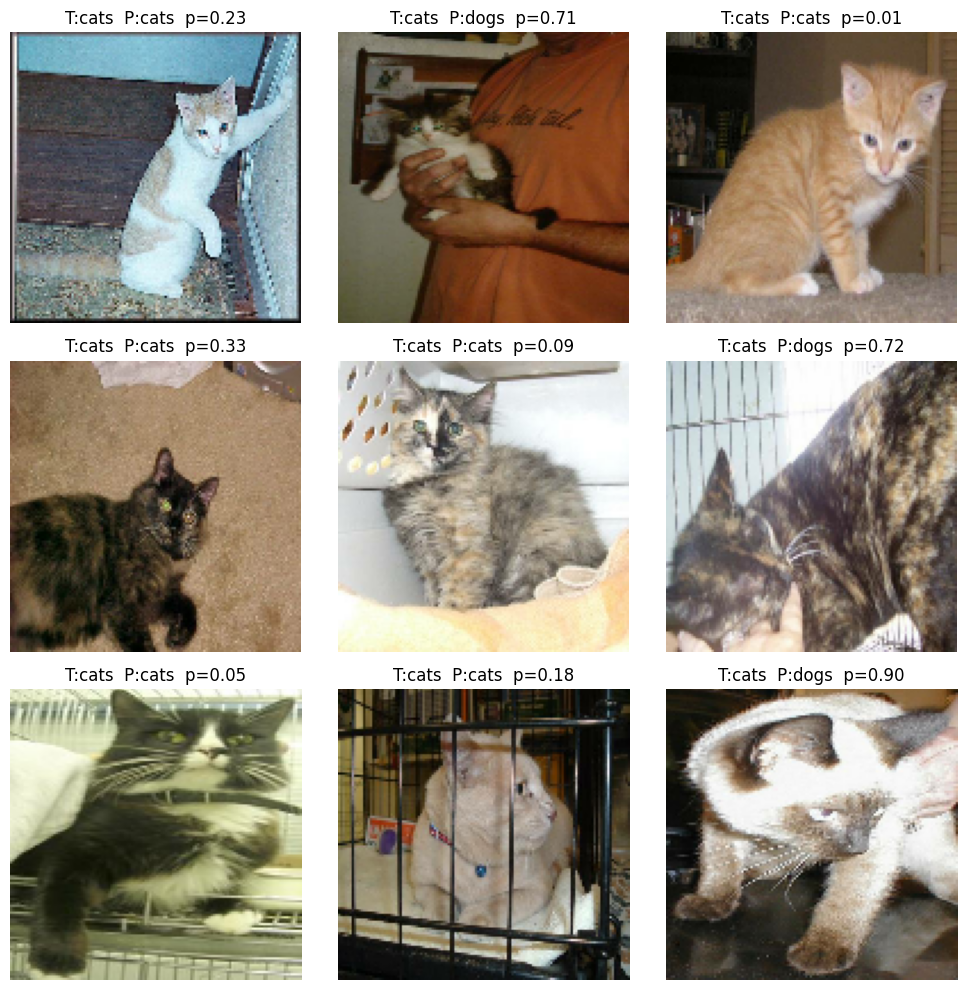

In [14]:
#grab one batch from test set (shuffle=False so it's stable)
for images, labels in test_ds.take(1):
    batch_images = images.numpy()
    batch_labels = labels.numpy().ravel().astype(int)

batch_probs = model.predict(batch_images, verbose=0).ravel()
batch_preds = (batch_probs >= 0.5).astype(int)
#plotting the first 9 images in the batch with their true labels, predicted labels, and predicted probabilities to visually inspect how well the model is performing on individual samples.
plt.figure(figsize=(10,10))
for i in range(min(9, len(batch_images))):
    plt.subplot(3,3,i+1)
    plt.imshow(batch_images[i].astype("uint8"))
    true_name = class_names[batch_labels[i]]
    pred_name = class_names[batch_preds[i]]
    plt.title(f"T:{true_name}  P:{pred_name}  p={batch_probs[i]:.2f}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [15]:
model.save("cats_vs_dogs_final.keras")
print("Saved: cats_vs_dogs_final.keras")

Saved: cats_vs_dogs_final.keras
